# Исследование музыки

## Импортирование библиотек

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

## Парсинг данных

In [2]:
def scrape_billboard_data(url, num_iterations):
    df_list = []

    for i in range(num_iterations):
        req = requests.get(url, timeout=30000)
        soup = BeautifulSoup(req.text, 'lxml')

        track = []

        row = soup.find(
            'h3', attrs={'class': 'c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 u-font-size-23@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-245 u-max-width-230@tablet-only u-letter-spacing-0028@tablet'}
        )
        track.append(row.text.strip())

        for row in soup.find_all(
            'h3', attrs={'class': 'c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only'}
        ):
            track.append(row.text.strip())


        artist = []

        row = soup.find(
            'span', attrs={'class': 'c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet'}
        )
        artist.append(row.text.strip())

        for row in soup.find_all(
            'span', attrs={'class': 'c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only'}
        ):
            artist.append(row.text.strip())


        peak_pos = []

        row = soup.find(
            'span', attrs={'class': 'c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max lrv-u-padding-tb-050@mobile-max u-font-size-32@tablet'}
        )
        peak_pos.append(row.text.strip())

        for row in soup.find_all(
            'span', attrs={'class': 'c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max'}
        ):
            peak_pos.append(row.text.strip())


        last_week = []
        peak_pos = []
        wks_on_chart = []
        mas = []

        row = soup.find_all('span', attrs={'class': 'c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max lrv-u-padding-tb-050@mobile-max u-font-size-32@tablet'})
        for element in row:
            mas.append(element.text.strip())

        last_week.append(mas[::6])
        peak_pos.append(mas[1::6])
        wks_on_chart.append(mas[2::6])

        for row in soup.find_all('span', attrs={'class': 'c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max'}):
            mas.append(row.text.strip())

        last_week = mas[::6]
        peak_pos = mas[1::6]
        wks_on_chart = mas[2::6]

        data = {
            'Track': track,
            'Artist': artist,
            'Last Week': last_week,
            'Peak Position': peak_pos,
            'Weeks on Chart': wks_on_chart
        }
        df = pd.DataFrame(data)
        
        date_regex = r'(\d{4}-\d{2}-\d{2})'
        match = re.search(date_regex, url)
        if match:
            date = match.group(1)
            df['Date'] = date
            
        df_list.append(df)

        url = modify_date(url, 1)

    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df

In [3]:
def modify_date(url, num_iterations):
    date_regex = r'(\d{4}-\d{2}-\d{2})'
    match = re.search(date_regex, url)
    if match:
        date = match.group(1)
        modified_date = pd.to_datetime(date) - pd.DateOffset(weeks=num_iterations)
        modified_url = url.replace(date, str(modified_date.date()))
        return modified_url
    else:
        return None

In [4]:
def merge_dataframes(original_df, new_df):
    merged_df = pd.concat([original_df, new_df], ignore_index=True)
    return merged_df

## Предобработка данных

### Загрузка данных

In [7]:
data = pd.read_csv('C:/Users/larag/Downloads/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144000 entries, 0 to 143999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      144000 non-null  int64 
 1   Track           144000 non-null  object
 2   Artist          144000 non-null  object
 3   Last Week       144000 non-null  object
 4   Peak Position   144000 non-null  int64 
 5   Weeks on Chart  144000 non-null  int64 
 6   Date            144000 non-null  object
dtypes: int64(3), object(4)
memory usage: 7.7+ MB


*Промежуточный вывод*

В таблице присутствует лишний столбец `Unnamed: 0`, столбец `Date` необходимо привести к соответствующему типу данных, названия столбцов необходимо изменить

### Изменение названия столбцов

In [8]:
data = data.drop('Unnamed: 0', axis=1)
data.columns=['track', 'artist', 'last_week', 'peak_pos', 'weeks_on_chart', 'date']
data.head()

,track,artist,last_week,peak_pos,weeks_on_chart,date
0,Lovin On Me,Jack Harlow,9,1,8,2024-01-13
1,Cruel Summer,Taylor Swift,19,1,35,2024-01-13
2,Greedy,Tate McRae,24,3,16,2024-01-13
3,Paint The Town Red,Doja Cat,29,1,22,2024-01-13
4,I Remember Everything,Zach Bryan Featuring Kacey Musgraves,31,1,19,2024-01-13


*Промежуточный вывод*

Названия столбцов изменены, лишний столбец удалён

### Приведение типов данных

In [9]:
data['date'] = pd.to_datetime(data['date'])
data['last_week'] = data['last_week'].replace('-', np.nan).astype('Int64')
data.dtypes

track                     object
artist                    object
last_week                  Int64
peak_pos                   int64
weeks_on_chart             int64
date              datetime64[ns]
dtype: object

*Промежуточный вывод*

Типы данных соответствуют действительности

### Обработка пропусков

In [10]:
def missed(table):
    for row in table:
        print('В столбце', row, round(table[row].isna().sum()*100.0/len(table[row]), 2), '% пропусков')

In [11]:
missed(data)

В столбце track 0.0 % пропусков
В столбце artist 0.0 % пропусков
В столбце last_week 9.74 % пропусков
В столбце peak_pos 0.0 % пропусков
В столбце weeks_on_chart 0.0 % пропусков
В столбце date 0.0 % пропусков


*Промежуточный вывод*

Пропусков в таблице не обнаружено

### Обработка дубликатов

In [12]:
def dup(table):
    for row in table:
        print('В столбце ', row, ' ', round(table[row].duplicated().sum() * 100.0 / len(table[row]), 2), '% дубликатов', sep='')
    print('Полных дубликатов в таблице ', round(table.duplicated().sum() * 100.0 / len(table), 2), '%', sep='')

In [13]:
dup(data)

В столбце track 92.82% дубликатов
В столбце artist 96.31% дубликатов
В столбце last_week 99.93% дубликатов
В столбце peak_pos 99.93% дубликатов
В столбце weeks_on_chart 99.94% дубликатов
В столбце date 99.0% дубликатов
Полных дубликатов в таблице 0.0%


*Промежуточный вывод*

Полных дубликатов в таблице нет. Дубликаты по столбцам допускаются

### Добавление столбцов

In [14]:
data['year'] = data['date'].dt.year
data.head()

,track,artist,last_week,peak_pos,weeks_on_chart,date,year
0,Lovin On Me,Jack Harlow,9,1,8,2024-01-13,2024
1,Cruel Summer,Taylor Swift,19,1,35,2024-01-13,2024
2,Greedy,Tate McRae,24,3,16,2024-01-13,2024
3,Paint The Town Red,Doja Cat,29,1,22,2024-01-13,2024
4,I Remember Everything,Zach Bryan Featuring Kacey Musgraves,31,1,19,2024-01-13,2024


*Промежуточный вывод*

Необходимые столбцы добавленны

### Оценка полноты данных по годам

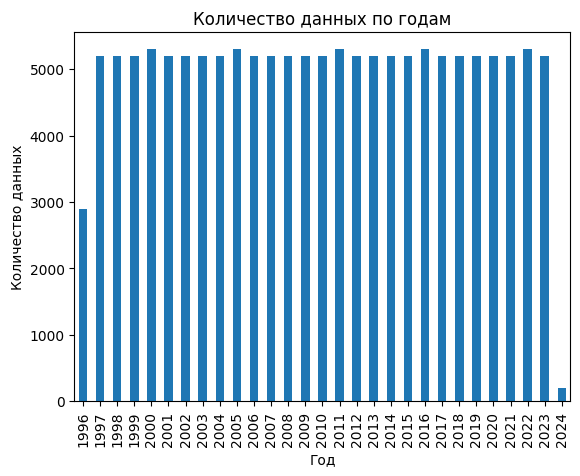

In [15]:
full_data = data.groupby('year')['track'].count()
full_data.plot(kind='bar')
plt.title('Количество данных по годам')
plt.xlabel('Год')
plt.ylabel('Количество данных')
plt.show()

*Промежуточный вывод*

Данные за 1996 и 2024 год неполные, их необходимо исключить из рассмотрения для обеспечения корректности вычислений. За весокосные годы данных немного больше

In [16]:
data = data.loc[(data['year'] != 1996) & (data['year'] != 2024)]

*Вывод*

Годы, за которые было собрано недостаточное количество данных, исключены из рассмотрения

## Описание данных

`track` - название трека

`artist` - исполнитель

`last_week` - количество недель с последнего появления в чарте

`peak_pos` - наивысшая позиция в чарте

`weeks_on_chart` - количество недель в чарте

`date` - дата выхода чарта

## Категоризация исполнителей

In [17]:
def categorize_artist(row, quartiles):
    if row['track'] >= quartiles.loc[0.99]:
        return '1'
    elif row['track'] >= quartiles.loc[0.95]:
        return '2'
    elif row['track'] >= quartiles.loc[0.75]:
        return '3'
    elif row['track'] >= quartiles.loc[0.5]:
        return '4'
    elif row['track'] >= quartiles.loc[0.25]:
        return '5'
    else:
        return '6'

In [18]:
grouped_data = data.groupby('artist')['track'].count().reset_index()
quartiles = grouped_data['track'].quantile([0.25, 0.5, 0.75, 0.95, 0.99])
grouped_data['category'] = grouped_data.apply(categorize_artist, quartiles=quartiles, axis=1)
data = data.merge(grouped_data[['artist', 'category']], on='artist', how='left')
data.head()

,track,artist,last_week,peak_pos,weeks_on_chart,date,year,category
0,All I Want For Christmas Is You,Mariah Carey,1,1,64,2023-12-30,2023,1
1,Rockin' Around The Christmas Tree,Brenda Lee,2,1,57,2023-12-30,2023,3
2,Jingle Bell Rock,Bobby Helms,3,3,55,2023-12-30,2023,3
3,Last Christmas,Wham!,4,4,37,2023-12-30,2023,3
4,A Holly Jolly Christmas,Burl Ives,5,4,38,2023-12-30,2023,3


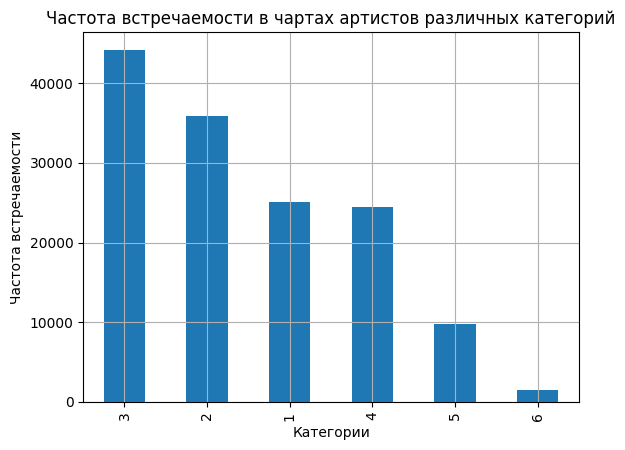

In [19]:
sorted_data = data['category'].value_counts().sort_values(ascending=False)
sorted_data.plot(kind='bar', grid=True)
plt.title('Частота встречаемости в чартах артистов различных категорий')
plt.xlabel('Категории')
plt.ylabel('Частота встречаемости')
plt.show()

*Вывод*

Категоризация исполнителей в зависимости от количества их песен в чарте произведена следующим образом: каждому исполнителю была присвоена категория в соответствии с количеством песен, вошедших в чарты. Для этого использовались квартили: 
- исполнители, чьи песни вошли в чарты среди 99% лучших, были отнесены к категории 1 (более 309 вхождений в чарт)

- исполнители с песнями в чартах среди 95% лучших - к категории 2 (от 94 до 309 вхождения в чарт)

- исполнители с песнями среди 75% лучших - к категории 3 (от 23 до 94 вхождений в чарт)

- исполнители с песнями среди 50% лучших - к категории 4 (от 14 до 23 вхождений в чарт)

- исполнители с песнями среди 25% лучших - к категории 5 (от 3 до 14 вхождений в чарт)

- исполнители с песнями ниже 25% (менее 3 вхождений в чарт) - к категории 6.

Чаще всего в чартах встречаются артисты категорий 3 и 2 (44 и 36 тыс. вхождений), далее идут группы 4 и 1 (25 и 26 тыс. вхождений) реже всего попадают в чарты - артисты категорий 5 и 6 (10 и 1.5 тыс вхождений)

## Оценка среднего по показателям

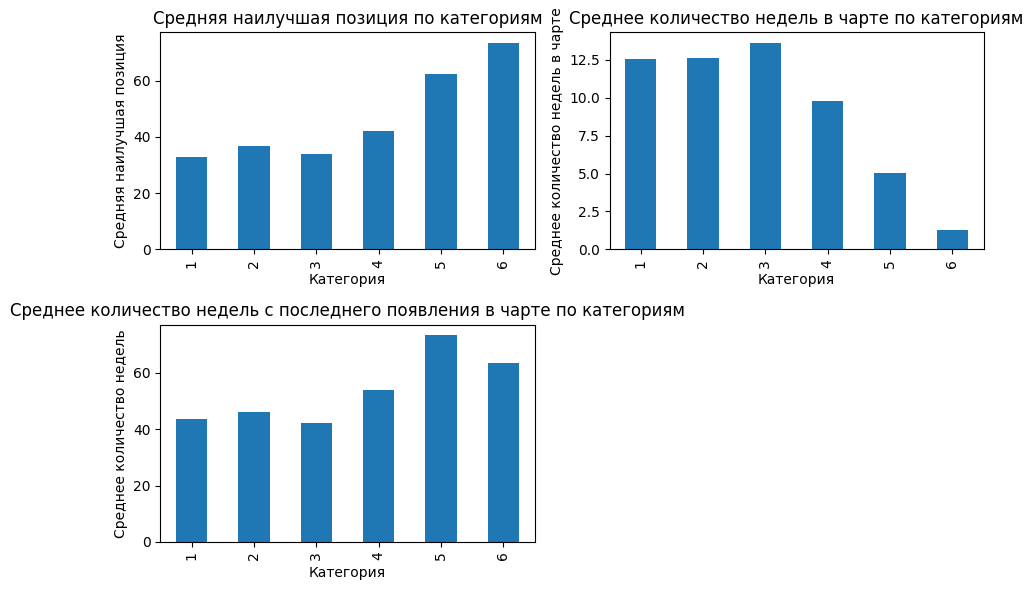

In [20]:
pos_table = data.groupby('category')['peak_pos'].mean()

plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
pos_table.plot(kind='bar')
plt.title('Средняя наилучшая позиция по категориям')
plt.xlabel('Категория')
plt.ylabel('Средняя наилучшая позиция')

weeks_table = data.groupby('category')['weeks_on_chart'].mean()

plt.subplot(2, 2, 2)
weeks_table.plot(kind='bar')
plt.title('Среднее количество недель в чарте по категориям')
plt.xlabel('Категория')
plt.ylabel('Среднее количество недель в чарте')

last_table = data.groupby('category')['last_week'].mean()

plt.subplot(2, 2, 3)
last_table.plot(kind='bar')
plt.title('Среднее количество недель с последнего появления в чарте по категориям')
plt.xlabel('Категория')
plt.ylabel('Среднее количество недель')

plt.tight_layout()

plt.show()

*Вывод*

Средняя наилучшая позиция в чарте для категорий 1, 2 и 3 находится примерно на одном уровне (небольшое увеличение для категории 2) - около 37. Для остальных категорий наблюдается резкое увеличение показателей, достигая значения 42 для категории 4, 61 для категории 5 и 65 для категории 6.

Среднее количество недель в чарте относительно стабильно для категорий 1, 2 и 3, находясь на уровне около 12.5 с небольшим увеличением до 12.7 для категории 3. Однако для категорий 4, 5 и 6 наблюдается резкое снижение показателя до 10 для категории 4, до 5.2 для категории 5 и до 1.1 для категории 6.

Среднее количество недель с последнего появления в чарте также относительно стабильно и находится в районе 40 пунктов для групп 1, 2 и 3, с небольшим увеличением для группы 2. Для группы 4 наблюдается увеличение до 43 недель, для группы 5 - до 65 недель, а для группы 6 - до 59 недель.

Группы 1, 2 и 3 стабильны относительно друг друга и демонстрируют хорошие показатели, в то время как группы 4, 5 и 6 отстают по всем показателям 

## Оценка динамики показателей

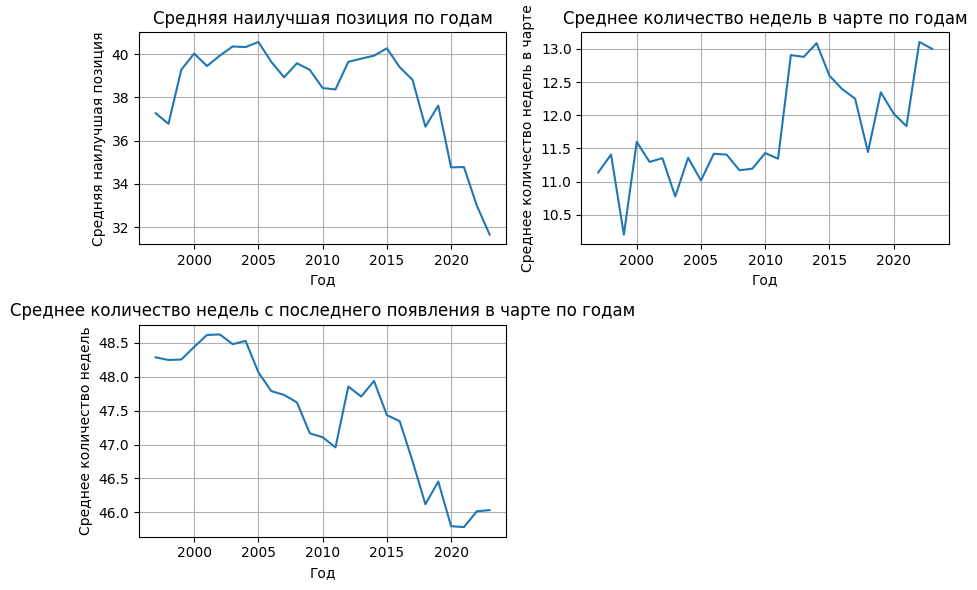

In [21]:
plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
pos_table = data.groupby('year')['peak_pos'].mean()
pos_table.plot(grid=True)
plt.title('Средняя наилучшая позиция по годам')
plt.xlabel('Год')
plt.ylabel('Средняя наилучшая позиция')

plt.subplot(2, 2, 2)
weeks_table = data.groupby('year')['weeks_on_chart'].mean()
weeks_table.plot(grid=True)
plt.title('Среднее количество недель в чарте по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество недель в чарте')

plt.subplot(2, 2, 3)
last_table = data.groupby('year')['last_week'].mean()
last_table.plot(grid=True)
plt.title('Среднее количество недель с последнего появления в чарте по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество недель')

plt.tight_layout()

plt.show()

*Вывод*

После небольшого снижения в 1998 году, показатель средней наилучшей позиции в чарте к 2000 году улучшился до 40 и оставался относительно стабильным до 2015 года, за исключением спада до 37 в 2010-2011 годах. Однако, с 2015 до 2023 года наблюдается сильное снижение показателя до 32 пунктов.

Показатель среднего количества недель в чарте также показывает интересные тенденции. После снижения на 1 пункт в 1999 году, показатель улучшился к 2000 году и оставался стабильным относительно отметки в 11.3 пункта до 2010 года. В 2010 году произошёл резкий скачок показателя до 13 пунктов, и высокие показатели держались до 2014 года. После этого был спад в 2015-2021 годы. К 2024 году показатель вышел на уровень 2010 года.

Показатель количества недель с последнего появления в чарте оставался стабильным относительно отметки в 48.5 пунктов до 2004 года, затем показал продолжительный спад до 2011 года, с последующим восстановлением в 2011-2016 годы. Однако, с 2016 года наблюдается спад до 46 пунктов.

*За последние 20 лет на 20% больше исполнителей стало получать высокие места в рейтинге, на 19% увеличилось среднее время нахождения в рейтинге и на 5% уменьшилось количество недель с последнего появления в чарте*

## Количество исполнителей из топ-20, попавших в чарты

In [22]:
top = data.groupby('artist')['track'].count().sort_values(ascending=False).head(20)
top_data = data[data['artist'].isin(top.index)]

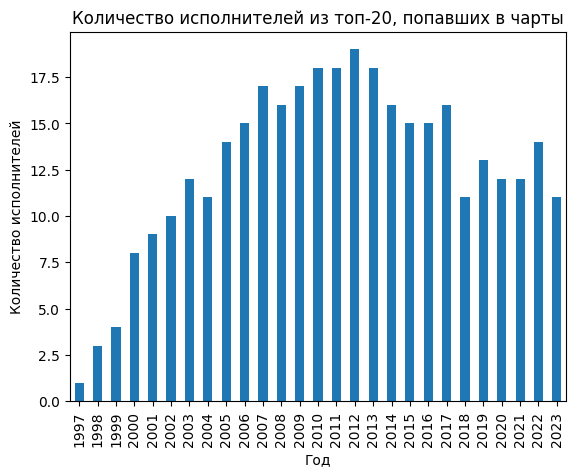

In [23]:
top_data.groupby('year')['artist'].nunique().plot(kind='bar')
plt.title('Количество исполнителей из топ-20, попавших в чарты')
plt.xlabel('Год')
plt.ylabel('Количество исполнителей')
plt.show()

*Вывод*

Дольше всех в чарте Billboard в 1997-2023 годах находились: Taylor Swift, Drake, Kenny Chesney, Tim McGraw, Keith Urban, Morgan Wallen, Jason Aldean, Rascal Flatts, Rihanna, P!nk, Luke Bryan, Beyonce, Carrie Underwood, Brad Paisley, George Strait, Blake Shelton, Kelly Clarkson, Toby Keith, Maroon 5, Ed Sheeran

До 2011 года исполнители из топ-20 непрерывно наращивали свою популярность, все чаще попадая в чарты. Однако начиная с 2011 года их популярность начала снижаться. Чаще всего исполнители из топ-20 активно присутствовали в чартах с 2010 по 2013 годы, включая более 18 исполнителей. Однако начиная с 2018 года, исполнители из топ-20 стали на 38% реже попадать в чарты по сравнению с периодом 2010-2013 годов. *Наиболее популярные исполнители постепенно утрачивают свою популярность*

## Наиболее популярные темы, встречающиеся в названиях песен

In [29]:
data['track_cleaned'] = data['track'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data['track_words'] = data['track_cleaned'].apply(lambda x: x.lower().split())
word_counts = Counter([word for words in data['track_words'] for word in words])
most_common_words = word_counts.most_common(10)

Слово "love" встречалось в названиях песен, входивших в чарт 5981 раз (седьмое место по популярности), слово "girl"/"girls"/"woman"/"baby" - 4035 раз, слово "good" - 1576 раз, слово "life" - 1409 раз, слово "heart" - 1142 раза, слово "party" - 691 раз, "money" - 528 раз, "christmas" - 456 раз

In [26]:
def theme(track_words):
    if 'christmas' in track_words:
        return 'рождество'
    if 'money' in track_words:
        return 'деньги'
    if 'party' in track_words or 'dance' in track_words:
        return 'вечеринки'
    if 'life' in track_words:
        return 'жизнь'
    if 'good' in track_words:
        return 'хорошее'
    if 'girl' in track_words or 'girls' in track_words or 'woman' in track_words or 'baby' in track_words:
        return 'женщины'
    if 'love' in track_words or 'kiss' in track_words:
        return 'любовь'
    return 'undef'

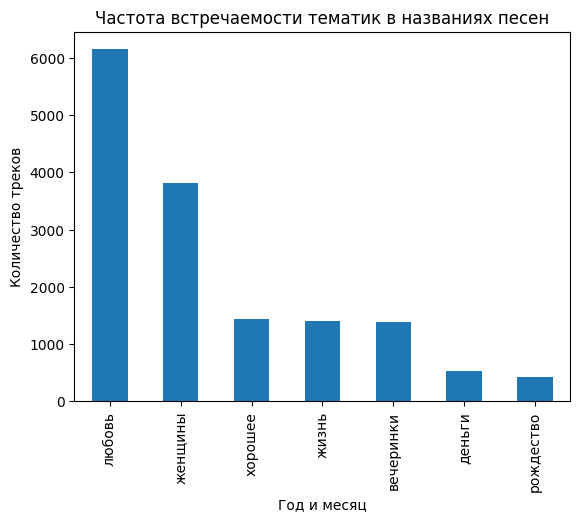

In [27]:
data['theme'] = data['track_words'].apply(theme)
theme_data = data.loc[data['theme'] != 'undef'].copy()
theme_data['theme'].value_counts().sort_values(ascending=False).plot(kind='bar')

plt.title("Частота встречаемости тематик в названиях песен")
plt.xlabel("Год и месяц")
plt.ylabel("Количество треков")
plt.show()

*Вывод*

Чаще всего в названиях песен говорится о любви и женщинах, далее идет хорошее, жизнь и вечеринки, замыкают список деньги и рождество

## Сезонность для тем, встречающихся в названиях песен

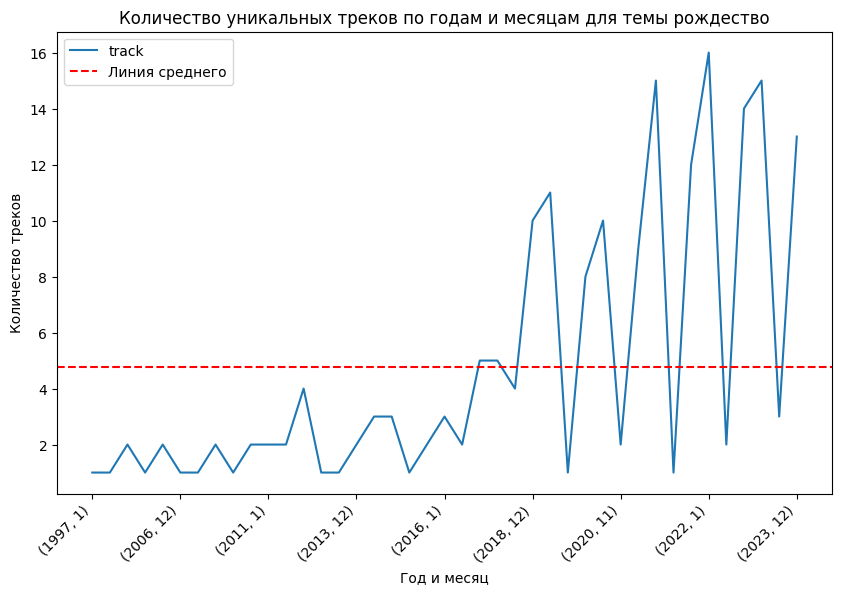

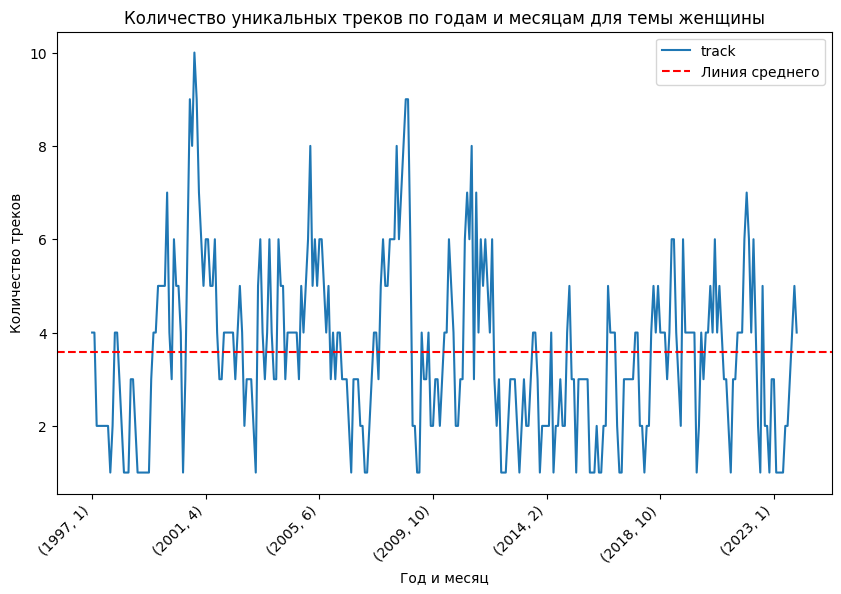

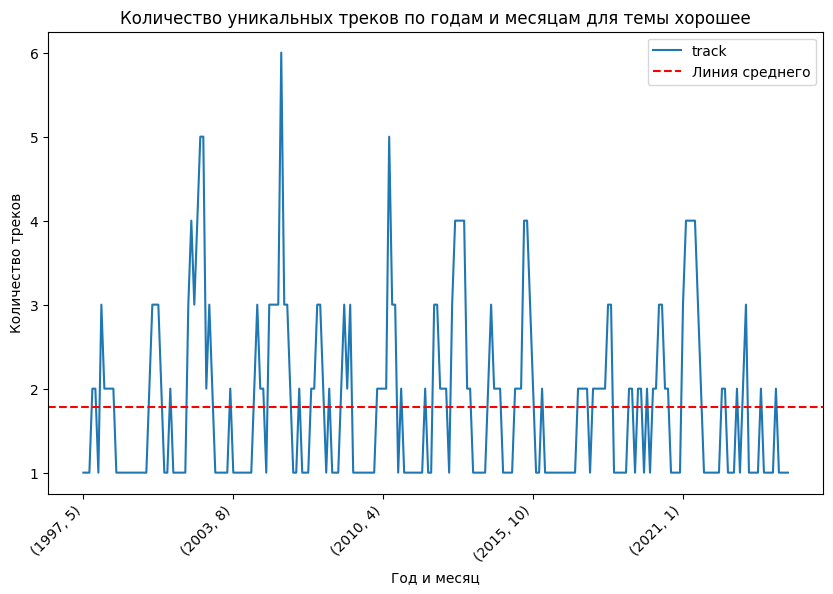

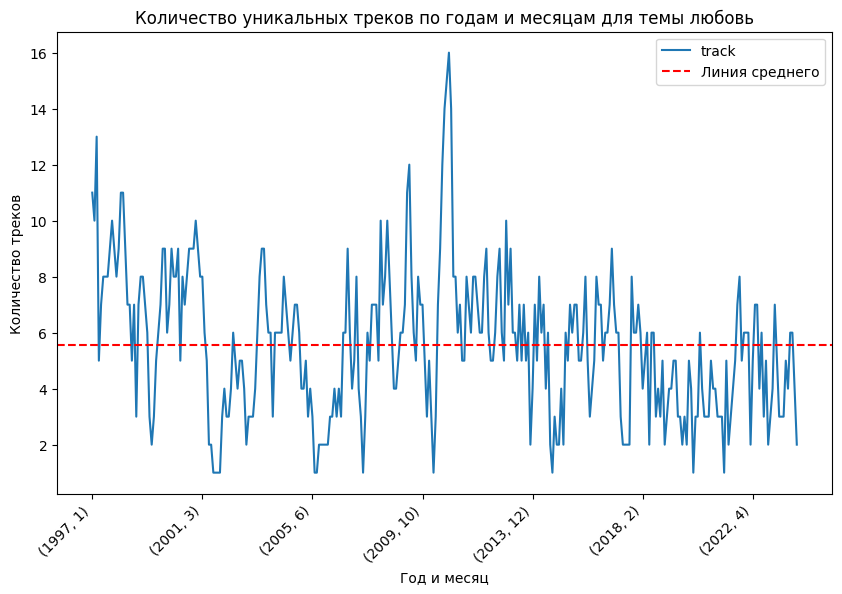

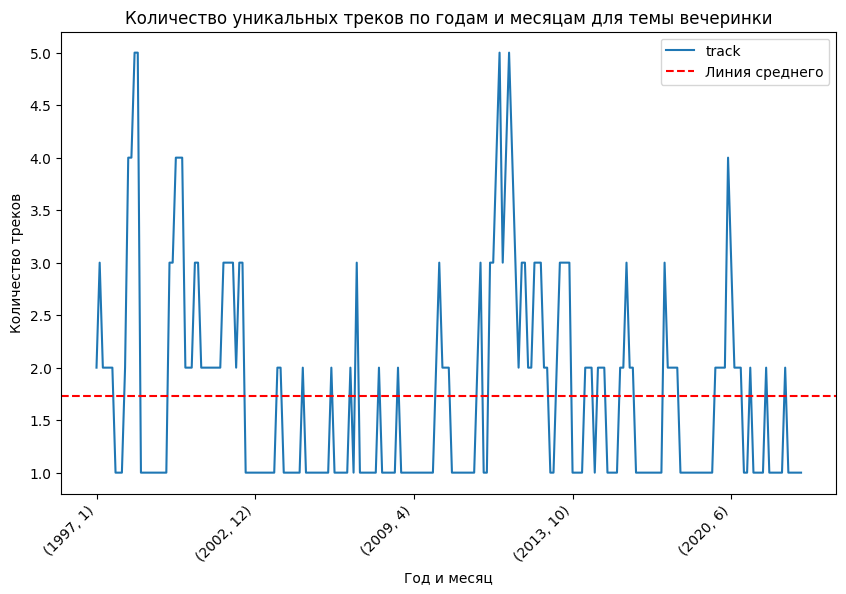

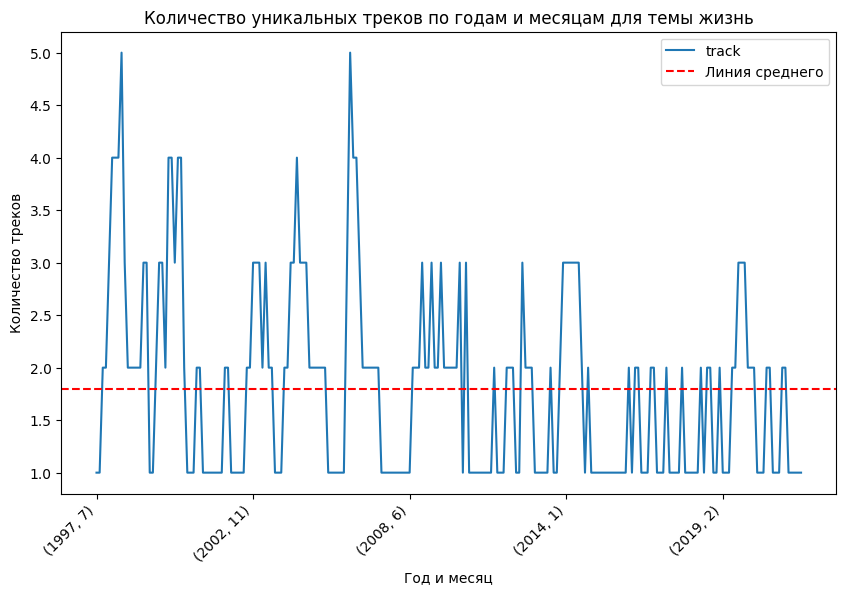

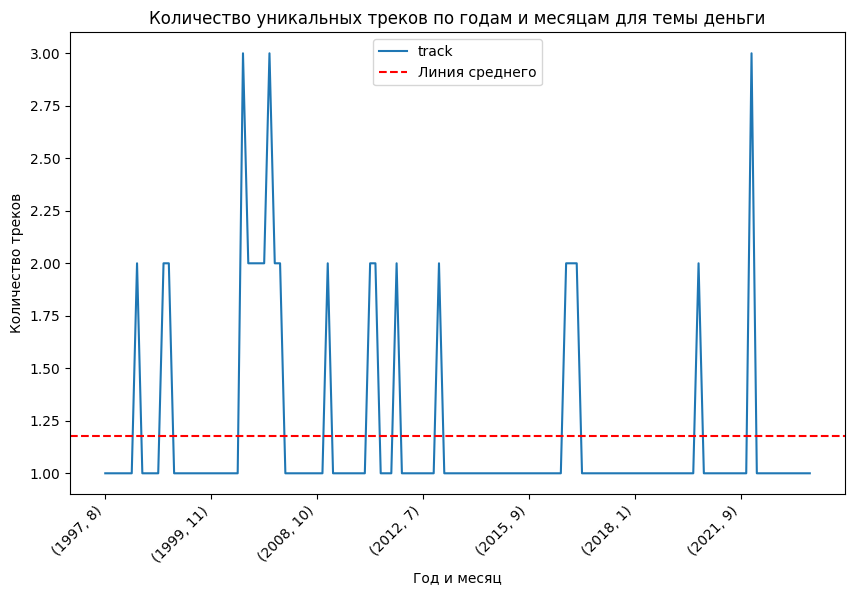

In [32]:
theme_data = data.loc[data['theme'] != 'undef'].copy()
theme_data['month'] = theme_data['date'].dt.month

overall_plot_data = theme_data.groupby(['year', 'month'])['track'].nunique()

for theme in theme_data['theme'].unique():
    good_theme_data = theme_data.loc[theme_data['theme'] == theme]
    plot_data = good_theme_data.groupby(['year', 'month'])['track'].nunique()
    overall_average = plot_data.mean()

    plt.figure(figsize=(10, 6))
    plot_data.plot()
    plt.axhline(overall_average, color='red', linestyle='--', label='Линия среднего')  # Plot the overall average line
    plt.title(f"Количество уникальных треков по годам и месяцам для темы {theme}")
    plt.xlabel("Год и месяц")
    plt.ylabel("Количество треков")
    plt.xticks(rotation=45, ha='right')
    plt.legend()  # Show the legend with the average line

    plt.show()


Тема рождества традиционно популярна в декабре и январе. На период 2023 года количество треков о рождестве, попавших в чарты Billboard, увеличилось в 8 раз по сравнению с 1997 годом

Динамика популярности темы женщин в песнях неоднородна: наиболее часто песни о женщинах попадали в чарты в 2001, 2005 и 2008 годах. Популярность этих треков ноибольшая к середине года и уменьшается к концу года, на 2023 их популярность была близка к средней

Наибольшую популярность треки о хорошем имели в 2002, 2004 и 2011 годах. К 2023 году их популярность снизилась

Тема любви в песнях имела наибольшую популярность в 1997 и 2010 году, наименьшую - в 2005 и 2014 годах. К 2024 популярность этих треков приблизилась к среднему

О вечеринках чаще всего пели в 1998 и 2012 годах, реже всего в период с 2002 по 2008 и с 2021 года

О жизни чаще всего пели в 1998 и 2007 году. С 2015 года эта тема относительно непопулярна

Тема денег наиболее популярнаа была в 2007 году. Былая популярность к этой теме вернулась в 2022 году, однако далее резко снизилась

## Выводы

- Чаще всего встречаются исполнители, входившие в чарт от 23 до 94 недель, реже всего - менее 3 недель. Исполнители, попавшие в чарт, чаще всего находятся в нём продолжительное время

- Исполнители, продержавшиеся в чарте от 94 недель, демонстрируют относительно равные хорошие показатели по всем рассматриваемым категориям: средняя наилучшая позиция, среднее количество недель и среднее количество недель с последнего появления в чарте. Артисты, находившиеся в чарте менее приведённого порога, показывают значительно худшие показатели

- За последние 20 лет на 20% больше исполнителей стало получать высокие места в рейтинге, на 19% увеличилось среднее время нахождения в рейтинге и на 5% уменьшилось количество недель с последнего появления в чарте

- Чаще всего исполнители из топ-20 входили в чарт с 2010 по 2013 год (более 18 исполнителей). С 2018 года исполнители из топ-20 попадают в чарт на 38% реже по сравнению с периодом 2010-2013 годов. Наиболее популярные исполнители постепенно утрачивают свою популярность

- Чаще всего в названиях песен говорится о любви и женщинах, далее идет хорошее, жизнь и вечеринки, замыкают список деньги и рождество. Динамика популярности наиболее часто встречающихся тем неоднородна